<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt

from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet, InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
#model.summary()

We start by freezing all of the base model’s layers. We don’t want to train those layers since we are trying to leverage the knowledge learned by the network from the previous dataset (in this case ImageNet). By setting the layer.trainable=False , we are telling Keras not to update those weights during training, which is exactly what we want!

In [0]:
base_model.trainable = False 

get the validation data

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [0]:
bs = 16

In [0]:
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train',  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1296 images belonging to 6 classes.


In [0]:
train_generator.image_shape

(200, 200, 3)

In [0]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


In [0]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train', 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 324 images belonging to 6 classes.


In [0]:
#default learning rate of 0.01 and no momentum is used
model.compile(optimizer=SGD(),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val=val_generator.n//val_generator.batch_size
print(step_size_val)

81
20


In [0]:
initial_epochs = 10

In [0]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

Epoch 1/10
81/81 [==============================] - 27s 335ms/step - loss: 0.3147 - acc: 0.9113 - val_loss: 0.0540 - val_acc: 0.9875
Epoch 2/10
81/81 [==============================] - 23s 281ms/step - loss: 0.0571 - acc: 0.9877 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 3/10
81/81 [==============================] - 22s 276ms/step - loss: 0.0380 - acc: 0.9915 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 4/10
81/81 [==============================] - 22s 276ms/step - loss: 0.0337 - acc: 0.9931 - val_loss: 0.0167 - val_acc: 0.9903
Epoch 5/10
81/81 [==============================] - 23s 279ms/step - loss: 0.0172 - acc: 0.9977 - val_loss: 0.0054 - val_acc: 0.9968
Epoch 6/10
81/81 [==============================] - 23s 278ms/step - loss: 0.0163 - acc: 0.9969 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 7/10
81/81 [==============================] - 22s 275ms/step - loss: 0.0193 - acc: 0.9946 - val_loss: 0.0083 - val_acc: 0.9968
Epoch 8/10
81/81 [==============================] - 22s 275ms/step - 

In [0]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

20/20 [==============================] - 4s 204ms/step
Validating loss: 0.004614139127079397
Validating accuracy: 0.996875


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

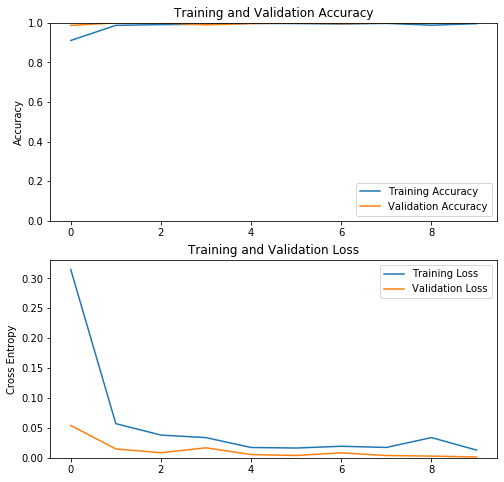

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
#plt.savefig('/content/drive/My Drive/xai_model/MN_80_20_SGD_27.jpg')
plt.show()



In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [0]:
fine_tune_at = 59

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
#model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [0]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 11/15
81/81 [==============================] - 24s 295ms/step - loss: 0.0095 - acc: 0.9977 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 12/15
81/81 [==============================] - 23s 280ms/step - loss: 0.0174 - acc: 0.9954 - val_loss: 0.0034 - val_acc: 0.9968
Epoch 13/15
81/81 [==============================] - 22s 275ms/step - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0067 - val_acc: 0.9968
Epoch 14/15
81/81 [==============================] - 22s 275ms/step - loss: 0.0072 - acc: 0.9985 - val_loss: 0.0087 - val_acc: 0.9968
Epoch 15/15
81/81 [==============================] - 22s 275ms/step - loss: 0.0168 - acc: 0.9938 - val_loss: 0.0096 - val_acc: 0.9968


In [0]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

20/20 [==============================] - 4s 201ms/step
Validating loss: 0.0010951852260404848
Validating accuracy: 1.0


In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

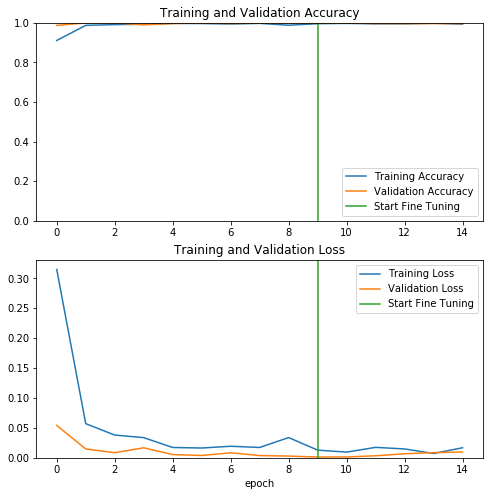

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
#plt.savefig('/content/drive/My Drive/xai_model/MN_FT_80_20_SGD_27.jpg')
plt.show()

In [0]:
#model.save('/content/drive/My Drive/xai_model/model_26.h5')

In [0]:
#model.save_weights('/content/drive/My Drive/xai_model/weights_24.h5')

Prediction on model 23

In [0]:
model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [24]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test',
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 180 images belonging to 6 classes.


In [25]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)
test_generator.reset()

180


In [26]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

180/180 [==============================] - 3s 19ms/step


In [0]:
predIndxs = np.argmax(predIndxs, axis=1)

In [28]:
print(classification_report(test_generator.classes, predIndxs, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        30
          In       1.00      1.00      1.00        30
          PS       1.00      1.00      1.00        30
          Pa       1.00      1.00      1.00        30
          RS       1.00      1.00      1.00        30
          Sc       1.00      1.00      1.00        30

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [31]:
cm = confusion_matrix(test_generator.classes,predIndxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5]) / total

print(cm)
print("Accuracy: {:.4f}".format(acc))

[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]]
Accuracy: 1.0000


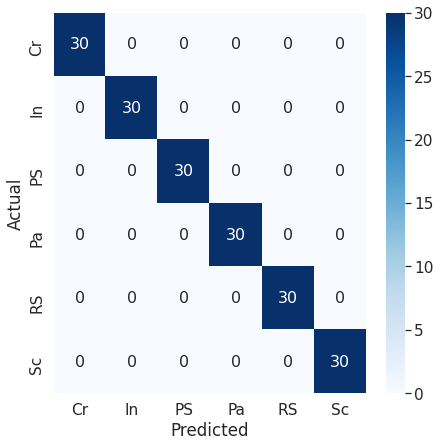

In [35]:
import seaborn as sn
import pandas as pd
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt.figure(figsize = (7,7))
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
# plt.savefig('/content/drive/My Drive/xai_model/MN_CM_26.jpg')

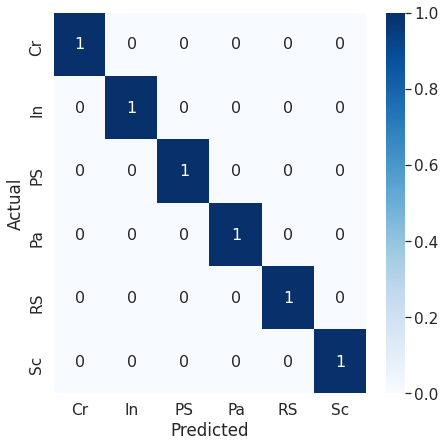

In [36]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt.figure(figsize = (7,7))
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.savefig('/content/drive/My Drive/xai_model/MN_NCM_1.jpg')

approach 2


In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [0]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test2',
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 1 images belonging to 1 classes.


In [0]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)

test_generator.reset()

1


In [0]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

1/1 [==============================] - 0s 33ms/step


In [0]:
predIndxs = np.argmax(predIndxs, axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predIndxs]

In [0]:
print(predIndxs)
print(labels)
print(predictions)

[1]
{0: 'Cr', 1: 'In', 2: 'PS', 3: 'Pa', 4: 'RS', 5: 'Sc'}
['In']


In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results.to_csv('/content/drive/My Drive/XAI_results/results2.csv',index=False)

In [0]:
#print(confusion_matrix(labels,predIndxs))

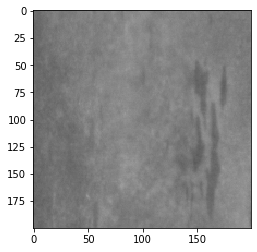

In [0]:
img = image.load_img('/content/drive/My Drive/NEU surface defect database - test split/Test/In/In_150.bmp', target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


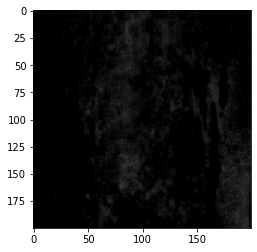

In [0]:
plt.imshow(img[0])

In [0]:
img = cv2.imread('/content/drive/My Drive/NEU surface defect database - test split/Test/In/In_150.bmp')
img = np.reshape(img,[-1, 200, 200, 3])

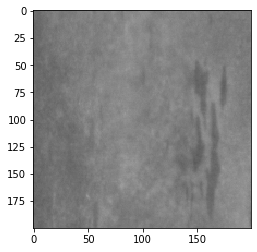

In [0]:
plt.imshow(img[0])

In [0]:
from PIL import Image
jpgfile = Image.open('/content/drive/My Drive/NEU surface defect database - test split/Test/In/In_150.bmp')

In [0]:
result = model.predict(jpgfile)
print(result)

AttributeError: ignored

In [0]:
argm = result.argmax(axis=1)
print(argm)

output = labels[int(argm)]
print(output)

[5]
Sc
